In [17]:
#import tigramite.independence_tests as it
#import tigramite.lpcmci as tg
import pandas as pd
import networkx as nx
import seaborn as sns

#import importlib
#importlib.reload(tp)

import numpy as np

from matplotlib import pyplot as plt
%matplotlib inline     

import tigramite
from tigramite import data_processing as dp #pp
#from tigramite.toymodels import structural_causal_processes as toys
from tigramite import plotting as tp
from tigramite.lpcmci import LPCMCI
from tigramite.pcmci import PCMCI
from tigramite.independence_tests import CMIknn, GPDC, ParCorr, CMIsymb, RobustParCorr

import time
import dcor
from sklearn import gaussian_process



In [168]:
#Other tuning choices
mid250 = 'CAMS_CAMS-CSM1-0_r1i1p1f1'  #Pc&GT=.66>GG&SA=.18
low500 = 'AWI_AWI-CM-1-1-MR_r1i1p1f1' #Pc&GT=.80>GG&SA=.23
high500 = 'CMCC_CMCC-ESM2_r1i1p1f1'   #Pc&GT=.88>GG&SA=.47. 
mid500 = 'AS-RCEC_TaiESM1_r1i1p1f1'   #Pc&GT=.52<GG&SA=.59<Pc->EN+1=.75. 
mid1000 = 'CSIRO_ACCESS-ESM1-5_r1i1p1f1' #Pc&GT=.81<GG&SA=.52

#amip-piF 
not_work = 'CCCma_CanESM5_r1i1p2f1' #1000 MI: Pc&GT=.86>GG&SA=.31!
CNRM = 'CNRM-CERFACS_CNRM-CM6-1_r1i1p1f2' #Pc&GT=.69>GG&SA=.23
IPSL = 'IPSL_IPSL-CM6A-LR_r1i1p1f1'       #Pc&GT=1.0>GG&SA=.28
just_2 = 'MRI_MRI-ESM2-0_r1i1p1f1'           #Pc&GT=.46~GG&SA=.44 this just2 guy was the only one this had a chance of helping if Pc&GT was really the problem.
both = 'NCAR_CESM2_r1i1p1f1' #1200            Pc&GT=.72>GG&SA=.44

chosen = IPSL

#possible extensions include nothing, (-ts,) and -TT
fname = '~/Documents/MATLAB/MMM_Analysis/data/LPCMCI/csv/'+chosen+'-TT.csv'#
df = pd.read_csv (fname)
df.pop('SB')
df.pop('Ph')
df.pop('L')
#df.pop('pr')
df_full = df
df_full_tg = dp.DataFrame(df.values, var_names = df.columns)
df

,EN,AMM,GG,Pc,TA,NA,SA,IN,GT,md,pr,TT
0,299.518066,296.176147,307.431091,299.478668,298.709076,298.092407,296.190552,299.843903,299.209137,295.870270,1.569743,206.010788
1,299.746460,296.578339,307.603302,299.122345,299.299622,298.625977,296.295380,299.812042,299.048645,295.045044,1.543072,205.514786
2,299.383179,295.789185,307.758026,298.551544,298.857452,298.147247,296.478943,299.516937,298.660645,295.397827,1.517635,205.368347
3,299.470123,296.244263,307.257507,299.077881,298.862274,298.209351,296.150604,299.468964,298.895355,295.811066,2.248350,205.735947
4,299.330414,296.583557,307.469086,298.572388,298.708191,297.842987,296.394897,299.548096,298.684570,296.022003,1.901916,205.541092
...,...,...,...,...,...,...,...,...,...,...,...,...
1195,298.798248,296.163330,307.114258,299.212738,298.793091,297.779755,295.709381,299.473907,298.907410,294.707275,1.266949,205.237717
1196,300.003784,296.368866,307.604767,299.475525,299.062134,297.892731,296.265656,299.796906,299.188416,294.837555,1.188275,205.765701
1197,300.110992,296.798309,308.016510,299.405212,299.323914,298.380524,296.434753,300.027771,299.253113,295.073273,1.011857,206.207275
1198,299.590149,296.240906,307.528015,298.375061,299.286896,298.276581,296.196564,299.854156,298.618256,295.877930,2.458160,205.366104


In [143]:
Hyp_pa = {
    'NA': [('NA', -1)],
    'md': [('md', -1)],
    'EN': [('IN', -1), ('Pc', -1)],
    'Pc': [('EN', 0), ('GG', 0), ('NA', 0)],
    'SA': [('GG', 0)],
    'TA': [('AMM', 0), ('EN', 0)],
    'AMM': [('EN', 0), ('TA', -1), ('NA', -1)],
    'GG': [('AMM', -1), ('NA', -1), ('SA', -1)],
    'IN': [('IN', -1), ('EN', -1)],
}
ideal_knn = {
    'CNRM': .4,
    'MRI': .2,
    'IPSL': .3,
    'NCAR': .3
}

In [169]:
import os
import pickle
Gs = os.listdir('Documents/MATLAB/MMM_Analysis/figures/LPCMCI/Ginsburg/new_bests/')
gs = [g for g in Gs if (chosen in g) and ('.png' in g)]# and ('-TT' in g)
g = gs[0]
print(g)
def get_param(p):
    pv = g.split('_'+p)[-1].split('_')[0]
    if p=='knn':
        return float('.'+pv)
    else:
        return int(pv)
IT1 = CMIknn(knn=get_param('knn'), shuffle_neighbors=get_param('SN')) #RobustParCorr() #GPDC() #
IT2 = CMIknn(knn=ideal_knn.get(chosen.split('_')[0].split('-')[0]), shuffle_neighbors=10) #RobustParCorr() #GPDC() #
for IT in [IT1, IT2]:
    IT.set_dataframe(df_full_tg)

fl = open('Documents/MATLAB/MMM_Analysis/figures/LPCMCI/Ginsburg/new_bests/'+g[:-4], 'rb')#
G = pickle.load(fl)
fl.close()

def graph_get(v1, v2, l):
    return G['graph'][G['var_names']==v1][0][G['var_names']==v2][0][-l]
def get_adjacent(var, tps):
    P = [(p, -np.where(tp==(G['graph'][G['var_names']==p][0][G['var_names']==var][0]))[0][0]) for p in G['var_names'] for tp in tps if tp in G['graph'][G['var_names']==p][0][G['var_names']==var]]
    return P
def get_index(var):
    return np.where(df_full.columns==var)[0][0]
def test(IT, X, Y, Z, add_parents, incl_potential):
    pa = ['-->']
    if incl_potential:
        pa += ['o->']
    if add_parents:
        Z_new = list(set(Z + get_adjacent(X[0], pa)+get_adjacent(Y[0], pa)))
        Z_new = [z for z in Z_new if not z[0] in [X[0], Y[0]]]
        print(Z_new)
    else:
        Z_new = Z
    return IT.run_test([(get_index(X[0]), X[1])], [(get_index(Y[0]), Y[1])], [(get_index(z[0]), z[1]) for z in Z_new])

IPSL_IPSL-CM6A-LR_r1i1p1f1-TT_SN11_knn3_p2_tm1.png


In [170]:
#<.05 is DEPENDENT. But I'm doing 10 tests now... but I want all of them to be true?
target = ('pr', 0)
condit = [('NA', 0), ('GT', 0), ('TA', 0)]
pr_adj = get_adjacent(target[0], ['o->','-->', '<->'])
pr_adj = [p for p in pr_adj if p not in condit+['TT']]
print(pr_adj)
for a in pr_adj:
    if a[1]<0:
        print("{}(-{}){}{}".format(a[0], a[1], graph_get(a[0], target[0], a[1]), target[0]))
    else:
        print("{}{}{}".format(a[0], graph_get(a[0], target[0], a[1]), target[0]))
    for it in [IT1, IT2]:
        #discovered; with and without potential parents
        print(test(it, a, target, condit, True, False))
        print(test(it, a, target, condit, True, True))
        #hypothesized
        hyp_pa = [(h[0], h[1]+a[1]) for h in Hyp_pa.get(a[0])]
        print(test(it, a, target, condit+hyp_pa, False, False))
        #both, with and without potential parents
        print(test(it, a, target, condit+hyp_pa, True, False))
        print(test(it, a, target, condit+hyp_pa, True, True))

[('EN', 0), ('Pc', 0), ('md', 0)]
EN-->pr
[('GT', 0), ('TA', 0), ('NA', 0)]
(0.010871987089668522, 0.0)
[('Pc', -1), ('TA', 0), ('GT', 0), ('NA', 0)]
(0.00541156055646308, 0.052)
(0.005518603611031736, 0.034)
[('Pc', -1), ('TA', 0), ('GT', 0), ('NA', 0), ('IN', -1)]
(0.005518603611031736, 0.034)
[('Pc', -1), ('TA', 0), ('GT', 0), ('NA', 0), ('IN', -1)]
(0.005518603611031736, 0.034)
[('GT', 0), ('TA', 0), ('NA', 0)]
(0.010871987089668522, 0.0)
[('Pc', -1), ('TA', 0), ('GT', 0), ('NA', 0)]
(0.005368622782144783, 0.028)
(0.0055488783751229676, 0.028)
[('Pc', -1), ('TA', 0), ('GT', 0), ('NA', 0), ('IN', -1)]
(0.0055488783751229676, 0.028)
[('Pc', -1), ('TA', 0), ('GT', 0), ('NA', 0), ('IN', -1)]
(0.0055488783751229676, 0.028)
Pc<->pr
[('TA', 0), ('EN', 0), ('SA', -1), ('GT', 0), ('NA', 0)]
(0.0035682090712345627, 0.508)
[('EN', -1), ('TA', 0), ('EN', 0), ('AMM', -1), ('SA', -1), ('GT', 0), ('NA', 0)]
(0.003454564727880971, 0.42)
(0.004066357283375233, 0.158)
[('GG', 0), ('TA', 0), ('EN', 0

In [82]:
G['graph'][G['var_names']=='NA'][0][G['var_names']=='NA'][0]

array(['', 'o->'], dtype='<U3')

In [163]:
G['var_names']

Index(['EN', 'AMM', 'GG', 'Pc', 'TA', 'NA', 'SA', 'GT', 'md', 'pr', 'TT'], dtype='object')

In [74]:
G['graph'][G['var_names']=='NA'][0]

array([['', ''],
       ['', ''],
       ['', ''],
       ['', ''],
       ['<--', ''],
       ['', 'o->'],
       ['', ''],
       ['', ''],
       ['-->', ''],
       ['-->', ''],
       ['', '']], dtype='<U3')

In [75]:
G['var_names']

Index(['EN', 'AMM', 'GG', 'Pc', 'TA', 'NA', 'SA', 'GT', 'md', 'pr', 'TT'], dtype='object')

In [61]:
G['graph'][G['var_names']=='NA'][0][G['var_names']=='NA']

array([['', 'o->']], dtype='<U3')

In [6]:
IT = CMIknn(knn=.3, shuffle_neighbors=10) #RobustParCorr() #GPDC() #
fl = open('Documents/MATLAB/MMM_Analysis/figures/LPCMCI/Ginsburg/new_bests/'+g[:-4], 'rb')#
IT.set_dataframe(df_full_tg)
def get_index(var):
    return np.where(df_full.columns==var)[0][0]
def test_short(X, Y, Z):
    return IT.run_test([(get_index(X[0]), X[1])], [(get_index(Y[0]), Y[1])], [(get_index(z[0]), z[1]) for z in Z])

In [11]:
test_short(('SA',0), ('pr',0), [('NA', 0), ('GT', 0)])#])

(0.011379554322424212, 0.01)

In [14]:
test(('pr',0), ('SA',0), [('NA', 0), ('GT', 0)], True)#('GT', 0)])

[('GT', 0), ('GG', 0), ('NA', 0)]


(0.010510643584978219, 0.004)

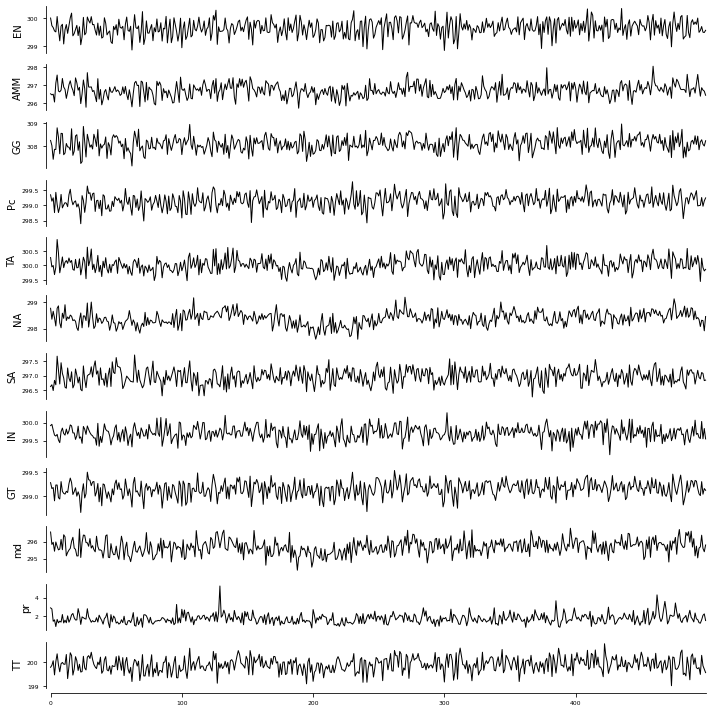

In [15]:
fig = tp.plot_timeseries(df_full_tg, figsize = [10, 10]); 
#sz = fig[0].get_size_inches()
#fig[0].set_size_inches([sz[0], sz[1]*3])
plt.show()

In [16]:
#IT = CMIknn(knn=0.2, shuffle_neighbors=13)#GPDC(significance='analytic')#
IT = CMIknn(knn=0.3, shuffle_neighbors=9) #RobustParCorr() #GPDC() #
#M_full = PCMCI(df_full_tg, IT, verbosity = 2)

In [219]:
var='EN'
[G['graph'][G['var_names']==p][0][G['var_names']==var] for p in G['var_names']]

[array([['', '']], dtype='<U3'),
 array([['', '']], dtype='<U3'),
 array([['', '']], dtype='<U3'),
 array([['', 'o->']], dtype='<U3'),
 array([['', '']], dtype='<U3'),
 array([['', '']], dtype='<U3'),
 array([['', '']], dtype='<U3'),
 array([['', '']], dtype='<U3'),
 array([['', '']], dtype='<U3'),
 array([['<--', '']], dtype='<U3'),
 array([['<--', '']], dtype='<U3')]

In [144]:
G['val_matrix'].max()

0.13182476537350318

In [ ]:
# Run the `PCMCI.run_bivci` function
#too slow for BOTH. 
#dependencies = M_full.run_bivci(tau_max=5, val_only=True)
#tests = 5
correlations = M_full.get_lagged_dependencies(tau_max=tests, val_only=True)

In [ ]:
# Plot the results
setup_args = {'var_names':df_full.columns,
              'figsize':(20, 20),
#              'x_base':5,
#              'y_base':.025,
              'minimum':0,
#              'maximum':.2
}
#need to change the fontsize too
lag_func_matrix = tp.plot_lagfuncs(val_matrix=dependencies['val_matrix'], 
                                   setup_args=setup_args)

In [ ]:
# Plot the results
setup_args = {'var_names':df_full.columns,
              'figsize':(20, 15),
             # 'x_base':5,
             # 'y_base':.025,
              'minimum':0,
             # 'maximum':1
             }
lag_func_matrix = tp.plot_lagfuncs(val_matrix=correlations['val_matrix'], 
                                   setup_args=setup_args)

In [ ]:
correlations['val_matrix'][2][6][0]

In [ ]:
correlations['val_matrix'][3][8][0]

In [ ]:
correlations['val_matrix'][3][0][1]

In [ ]:
max([correlations['val_matrix'][-1][i][0] for i in range(1,len(correlations['val_matrix'][-1]))])

In [ ]:
alpha1 = .05/tests
alpha2 = .33/tests
scatter_lags = np.argmax(np.abs(correlations['val_matrix'][:,:,:5]), axis=2)
scatter_lags_pos = scatter_lags.copy()
V=[[correlations['val_matrix'][r,c,scatter_lags[r,c]] for c in range(correlations['val_matrix'].shape[1])] for r in range(correlations['val_matrix'].shape[0])]
S=[[correlations['p_matrix'][r,c,scatter_lags[r,c]] for c in range(correlations['p_matrix'].shape[1])] for r in range(correlations['p_matrix'].shape[0])]
#SD = np.mean([np.mean([np.var(correlations[r,c,:]) for c in range(correlations.shape[1])]) for r in range(correlations.shape[0])])**.5
#Md = [[np.median(correlations[r,c,:]) for c in range(correlations.shape[1])] for r in range(correlations.shape[0])]
#SDp = np.mean(np.mean(SD))
#Mdp = np.mean(np.mean(Md))
for r in range(correlations['val_matrix'].shape[0]):
    for c in range(correlations['val_matrix'].shape[1]):
        if np.abs(S[r][c])>alpha1: #(np.abs(Mdp)+2*SDp):
            scatter_lags[r,c]=-1
        if np.abs(S[r][c])>alpha2: #(np.abs(Mdp)+SDp): #(Md[r][c]+1*SD):
            scatter_lags[r,c]=-2

scatter_lags

In [ ]:
for r in range(scatter_lags.shape[0]):
    for c in range(scatter_lags.shape[1]):
        if scatter_lags[r,c]>-1:
            print("{}->{}: {}".format(df_full.columns[r], df_full.columns[c], scatter_lags[r,c]))

In [ ]:
tp.plot_densityplots(dataframe=df_full_tg, add_densityplot_args={'matrix_lags':scatter_lags_pos}, 
                    setup_args = {
                        'figsize':(40, 30),
                        'label_fontsize':20,
                    }); plt.show()

In [ ]:
#developer for density function
#seaborn pairgrid penguins
#import seaborn

#sns.kdeplot, fill=True

L2 = len(df.columns)
fig, axs = plt.subplots(L2,L2, figsize=(20, 15))
for r in range(L2):
    for c in range(L2):
        l = scatter_lags[r,c]
        if (l<0):
            if (r==c):
                shift = 1
            else:
                shift=0
            #x = x[:-1]
            #y = y[1:]
        else:
            shift = l
        y = list(df.loc[shift:,df.columns[c]])
        x = list(df.loc[0:(len(y)-1),df.columns[r]])
        #elif l>0:
        #    x = x[:-l]
        #    y = y[l:]
        if l==-2:
            cr='gray'
        elif l==-1:
            cr='lightblue'
        else:
            cr='blue'
        sns.kdeplot(x=x,y=y, fill=True, ax=axs[r,c], color=cr)
        axs[r,c].text(0.1, 0.1, str(shift),
             horizontalalignment='center',
             verticalalignment='center',
             transform = axs[r,c].transAxes)
for i in range(L2):
    n = df.columns[i]
    axs[i,0].set(ylabel=n)
    axs[0,i].set_title('->'+n)

In [ ]:
results = M_full.run_pcmciplus(tau_max=5, pc_alpha=.5)#, max_combinations=10)

In [ ]:
#outside for loop
seasons = {
    'W':['EN'],
    'Sp': ['GG', 'AMM'],
    'Su': [b for b in df_full_tg.var_names if not b in ['EN', 'AMM', 'GG']]
}

x_vals = {'NA':5, 'md':6}
x_vals.update(dict.fromkeys(['IN'],2))
x_vals.update(dict.fromkeys(['EN', 'Pc'],3)) #Pacific, Winter and Summer
x_vals.update(dict.fromkeys(['GG', 'SA'],1)) #South Atlantic, Spring and Summer
x_vals.update(dict.fromkeys(['AMM', 'TA'],4)) #Tropical Atlantic, Spring and Summer , 'pr'
x_vals.update(dict.fromkeys(['GT'],3)) #extras
EXTRA = ['SB', 'Ph', 'L'] #usually not included
EXTRA = [b for b in EXTRA if b in df_full_tg.var_names]
x_vals.update({EXTRA[i]:(i+6) for i in range(len(EXTRA))})
y_vals = {'EN':5.5, 'GT':2}#, 'pr':1} #Winter and extras
y_vals.update(dict.fromkeys(seasons.get('Sp'),4.5)) #Spring
y_vals.update({'GG':4.2})
su_basins_full = ['Pc', 'SA', 'TA', 'NA', 'md', 'SB', 'IN', 'Ph', 'L']
#inside for loop
su_basins = [vn for vn in su_basins_full if vn in df_full_tg.var_names]#[:-1]
r = len(su_basins)
y_vals.update({b:((r**2-(x_vals.get(b)-(r+1)/2)**2)**.5)-np.min([((3*r**2 + 2*r - 1)**.5)/2,r])+3 for b in su_basins})#
#y_vals.update({'IN':y_vals.get('IN')+.5})
x = [x_vals.get(vn) for vn in df_full_tg.var_names]
y = [y_vals.get(vn) for vn in df_full_tg.var_names]

In [ ]:
P = tp.plot_graph(
    val_matrix=results['val_matrix'],
    graph=results['graph'],
    var_names=df.columns, 
    node_pos={'x':x, 'y':list(y)}, 
    arrowhead_size=1, 
    arrow_linewidth=6, #node_size=0.5, 
    figsize=(10, 7),
    cmap_nodes = "RdBu_r",
    show_autodependency_lags=True,
    vmin_nodes=-1,
    alpha=.9
    ); 
#P[0].set_facecolor('lightgray')#'whitesmoke') #
P[0].suptitle(chosen)

In [ ]:
P = tp.plot_graph(
    val_matrix=G_full['val_matrix'],
    graph=G_full['graph'],
    var_names=df.columns, 
    node_pos={'x':x, 'y':list(y)}, 
    arrowhead_size=15, 
    arrow_linewidth=7, #node_size=0.5, 
    figsize=(10, 7),
    cmap_nodes = "RdBu_r",
    show_autodependency_lags=True,
    vmin_nodes=-1,
    alpha=1
    ); 
P[0].set_facecolor('lightgray')#'whitesmoke') #

In [ ]:
# Plot time series graph    
tp.plot_time_series_graph(
     figsize=(10, 8),
    val_matrix=results['val_matrix'],
    graph=results['graph'],
    var_names=df.columns, 
    node_size=0.05,
    curved_radius=0.6,
    ); plt.show()

In [ ]:
m = fname.split('csv/')[-1].split('_')[0]
fig.savefig('Documents/MATLAB/MMM_Analysis/figures/LPCMCI/'+m+'_Distribs.png')

In [ ]:
M_full = LPCMCI(df_full_tg, IT, verbosity = 1)
t1 = time.time()
G_full = M_full.run_lpcmci(tau_max=5,n_preliminary_iterations=2)#tau_max=5, 
t2 = time.time()
elapsed = (t2-t1)/3600 #in hours
elapsed

In [ ]:
x=np.array(df.EN[:-1])
y=np.array(df.EN[1:])
sns.displot(x=x, y=y, kind="kde", fill="true")

In [ ]:
np.corrcoef(x,y)